<a href="https://colab.research.google.com/github/mgarbanzo/UCR_NOAA_2020/blob/main/Generando_producto_de_Fase_Nubosidad_Diurna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

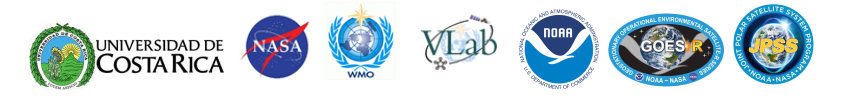

# Práctica de Python en la nube para generar el producto de Fase de Nubosidad Diurna con datos del sensor ABI de GOES 16

## Entrenamiento Virtual en Aplicaciones de Satélites para la RA-IV de la OMM



# Primero debemos obtener la información para visualizar.

Los enlaces mostrados se obtuvieron de [este enlace](http://home.chpc.utah.edu/~u0553130/Brian_Blaylock/cgi-bin/goes16_download.cgi?source=aws&satellite=noaa-goes16&domain=F&product=ABI-L2-CMIP&date=2019-07-17&hour=12).

Note que se comienza con la instrucción !wget donde:

Descargamos los datos ejecutando las siguientes dos casillas de código:

In [1]:
!wget https://noaa-goes16.s3.amazonaws.com/ABI-L2-CMIPF/2020/295/18/OR_ABI-L2-CMIPF-M6C02_G16_s20202951800195_e20202951809503_c20202951809587.nc
!wget https://noaa-goes16.s3.amazonaws.com/ABI-L2-CMIPF/2020/295/18/OR_ABI-L2-CMIPF-M6C05_G16_s20202951800195_e20202951809503_c20202951809592.nc
!wget https://noaa-goes16.s3.amazonaws.com/ABI-L2-CMIPF/2020/295/18/OR_ABI-L2-CMIPF-M6C13_G16_s20202951800195_e20202951809514_c20202951810007.nc

--2020-10-21 22:11:45--  https://noaa-goes16.s3.amazonaws.com/ABI-L2-CMIPF/2020/295/18/OR_ABI-L2-CMIPF-M6C02_G16_s20202951800195_e20202951809503_c20202951809587.nc
Resolving noaa-goes16.s3.amazonaws.com (noaa-goes16.s3.amazonaws.com)... 52.216.92.171
Connecting to noaa-goes16.s3.amazonaws.com (noaa-goes16.s3.amazonaws.com)|52.216.92.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 498152898 (475M) [binary/octet-stream]
Saving to: ‘OR_ABI-L2-CMIPF-M6C02_G16_s20202951800195_e20202951809503_c20202951809587.nc’

OR_ABI-L2-CMIPF-M6C 100%[===================>] 475.08M  35.1MB/s    in 14s     

2020-10-21 22:12:00 (33.4 MB/s) - ‘OR_ABI-L2-CMIPF-M6C02_G16_s20202951800195_e20202951809503_c20202951809587.nc’ saved [498152898/498152898]

--2020-10-21 22:12:00--  https://noaa-goes16.s3.amazonaws.com/ABI-L2-CMIPF/2020/295/18/OR_ABI-L2-CMIPF-M6C05_G16_s20202951800195_e20202951809503_c20202951809592.nc
Resolving noaa-goes16.s3.amazonaws.com (noaa-goes16.s3.amazonaws.com).

# Se requieren algunas librerías para poder leer datos satelitales

Una de las librerías más usadas para leer datos satelitales es **NetCDF4** que se instala con el siguiente comando:

In [2]:
!pip install netCDF4

     |████████████████████████████████| 4.3MB 8.5MB/s 
     |████████████████████████████████| 296kB 67.2MB/s 


Una vez instalada, se puede incorporar en Python junto a otras librería útiles para visualización y manipulación de arreglos de números:

In [3]:
import pylab as plt
from netCDF4 import Dataset                
import matplotlib.pyplot as plt           
#import cartopy, cartopy.crs as ccrs      
import numpy as np                      
from datetime import datetime

# Asignar el metadato a los datos es simple y rápido

En la casilla siguiente se utiliza el comando Dataset de la librería NetCDF4 para cargar los metadatos a las variables.

Los canales 2 y 5, al ser de nivel 2, están normalizados de 0 a 1. El canal 13 está en unidades de temperatura de Brillo y por eso se está restando 273.15 a los valores para convertirlos de $K$ a $C$.

Algo muy importante es que los tres canales tienen resoluciones diferentes siendo:

* 0.5 km para Canal 2
* 1 km para Canal 5
* 2 km para Canal 13

y por eso se deben leer únicamente los datos que permitan generar matrices del mismo tamaño que permitan unirlas en el producto final. Note que se leen los datos usando la indicación de entradas de Python siguientes:

Para Canal 2, obtenemos una de cada 4 entradas
> [::4 ,::4]

Para Canal 5, obtenemos una de cada 2 entradas
> [::2 ,::2]

Para Canal 13, obtenemos todas las entradas
> [::1 ,::1]

Al generar matrices del mismo tamaño MxM entonces podemos continuar la generación del producto.

In [4]:
# Se abre la imagen del GOES-16 para obtener información
file1 = Dataset("/content/OR_ABI-L2-CMIPF-M6C02_G16_s20202951800195_e20202951809503_c20202951809587.nc")
# Se extraen los valores de cada punto y se convierten de K a C
data02 = file1.variables['CMI'][:,:][::4 ,::4]

file2 = Dataset("/content/OR_ABI-L2-CMIPF-M6C05_G16_s20202951800195_e20202951809503_c20202951809592.nc")
data05 = file2.variables['CMI'][:,:][::2 ,::2]

file3 = Dataset("/content/OR_ABI-L2-CMIPF-M6C13_G16_s20202951800195_e20202951809514_c20202951810007.nc")
data13 = file3.variables['CMI'][:,:][::1 ,::1] - 273.15

Podemos confirmar que las matrices tienen las mismas dimensiones utilizando el programa shape de numpy de la siguiente manera:

In [6]:
np.shape(data02), np.shape(data05), np.shape(data13)

((5424, 5424), (5424, 5424), (5424, 5424))

# Generación de los colores Rojo (R), Verge (G), y Azul (B)

Se necesitan tres matrices para generar una imagen tipo RGB y la conformación de este producto (su receta o fórmula) es muy simple. Únicamente requiere asignar un canal a cada color.

**Importante: ** El color rojo debe ser invertido para el producto pero es el último paso que se realiza en este procedimiento antes de visualizar el RGB.

In [7]:
R = data13 # Canal 13
G = data02 # Canal 2
B = data05 # Canal 5

Se utilizan valores mínimo y máximo para delimitar las regiones de interés.

Este proceso por lo general es experimental para lograr un ajuste fino a las necesidades del producto.

Note que en este caso el color rojo (R) se calculó con la ecuación $$ R = CH_{13} $$ pero se define $$ R_{min} = -53.5 C $$ y $$ R_{max} = 7.5 C $$

de manera que $$ -53.5 C < R < 7.5 C $$.

Similarmente se hace para el color verde y azul.

In [8]:
# Establecemos los límites de cada color:

Rmin = -53.5
Rmax = 7.5

Gmin = 0.0
Gmax = 0.78

Bmin = 0.01
Bmax = 0.59

R[R > Rmax] = Rmax
R[R < Rmin] = Rmin

G[G > Gmax] = Gmax
G[G < Gmin] = Gmin

B[B > Bmax] = Bmax
B[B < Bmin] = Bmin 

gamma_R = 1
gamma_G = 1
gamma_B = 1
 
# Se normalizan los datos
R = ((R - Rmin) / (Rmax - Rmin)) ** (1/gamma_R)
G = ((G - Gmin) / (Gmax - Gmin)) ** (1/gamma_G)
B = ((B - Bmin) / (Bmax - Bmin)) ** (1/gamma_B)

# Este paso es MUY IMPORTANTE ya que es la inversión del color ROJO:

R = 1 - R

# Si el comando anterior no se ejecuta entonces la imagen se verá mayoritariamente roja.

Se genera la matriz de datos RGB que contiene las tres componentes de Rojo, Verde y Azul. También se crea una máscara para las regiones sin valores (espacio al rededor del planeta por ejemplo). 

In [9]:
# Create the RGB
RGB = np.stack([R, G, B], axis=2)

# Eliminate values outside the globe
mask = (RGB == [R[0,0],G[0,0],B[0,0]]).all(axis=2)
RGB[mask] = np.nan

# Graficación de las componentes de la imagen final

Ahora procedemos a generar productos individuales para cada canal del RGB que nos permita comprender mejor los colores generados.

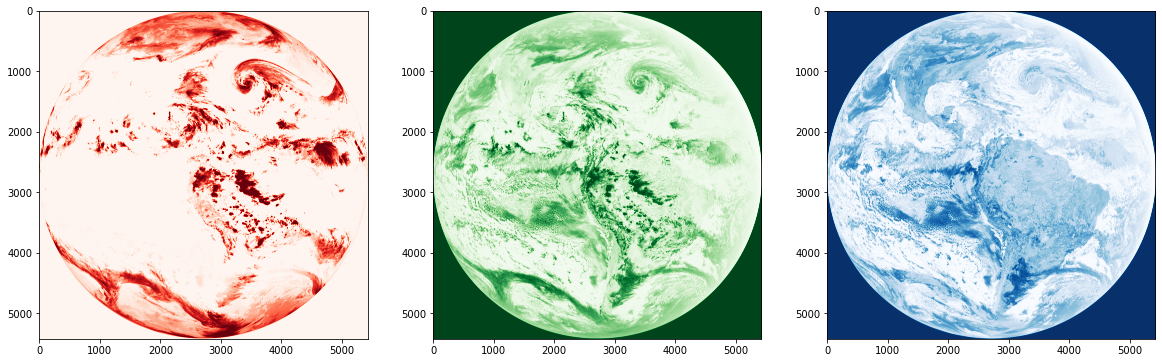

In [10]:
fig, [ax0, ax1, ax2] = plt.subplots(1, 3, figsize=(20,10))
ax0.imshow(R,cmap=plt.get_cmap('Reds'))
ax1.imshow(G,cmap=plt.get_cmap('Greens'))
ax2.imshow(B,cmap=plt.get_cmap('Blues'))

# Grafico final del producto RGB

Generamos el gráfico tipo RGB utilizando los tres colores mostrados anteriormente:

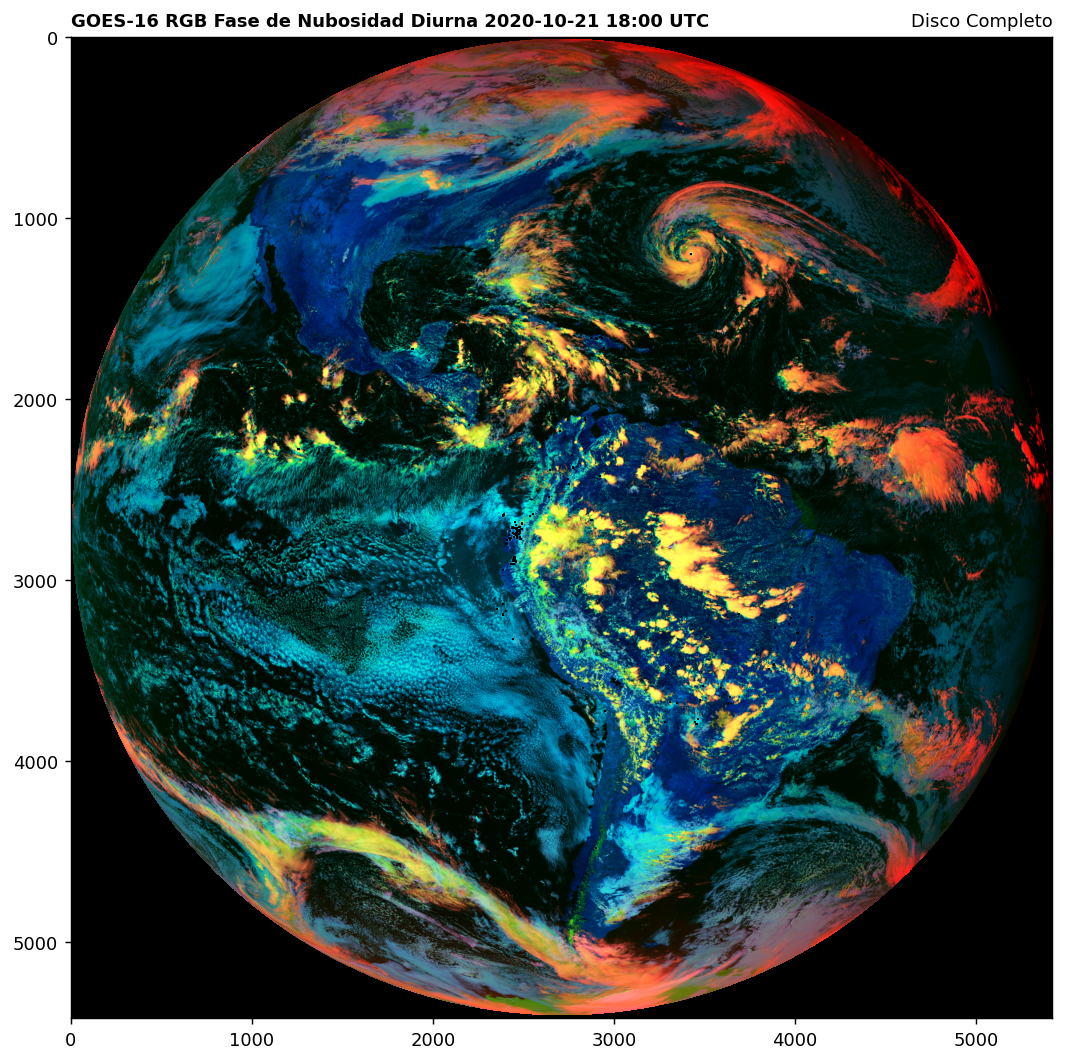

In [11]:
# Seleccionamos el tamaño y resolución de la imagen que necesitamos
plt.figure(figsize=(10,10),dpi=130) 
img = plt.imshow(RGB, origin='upper')

# Extraemos la fecha y hora de la imagen:
date = (datetime.strptime(file1.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ'))
	
# Agregamos un título al producto
plt.title('GOES-16 RGB Fase de Nubosidad Diurna ' + date.strftime('%Y-%m-%d %H:%M') + ' UTC', fontweight='bold', fontsize=10, loc='left')
plt.title('Disco Completo', fontsize=10, loc='right')

# Guardamos una copia de la imagen al archivo llamado Imagen_SO2.png
plt.savefig('FaseNubosidadDiurna.png')

# Mostramos el producto generado
plt.show()

# Podemos recortar una sección más pequeña y usar otro motor de graficación

Tenemos que instalar la librería mpld3 para poder hacer zoom y mover facilmente la imagen.


In [12]:
!pip install mpld3

     |████████████████████████████████| 1.0MB 7.9MB/s 
  Created wheel for mpld3: filename=mpld3-0.5.1-cp36-none-any.whl size=364064 sha256=914ac3d37817dd05256e998965505c5df9f03335b0cb494cf70ca0c4df4b7857
  Stored in directory: /root/.cache/pip/wheels/38/68/06/d119af6c3f9a2d1e123c1f72d276576b457131b3a7bf94e402
Successfully built mpld3


Cargamos la nueva librería para poder utilizarla al graficar:


In [13]:
import mpld3
from mpld3 import plugins

Recortamos los datos RGB y nombramos la nueva variable pRGB donde la p representa una matriz pequeña y luego graficamos nuevamente.


In [14]:
pRGB = RGB[1000:1500,3000:4000,:]

In [15]:
fig, ax = plt.subplots(figsize=(15,15))

im = ax.imshow(pRGB, origin='upper')

# Extract date
date = (datetime.strptime(file1.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ'))

# Add a title
plt.title('GOES-16 RGB Fase de Nubosidad Diurna ' + date.strftime('%Y-%m-%d %H:%M') + ' UTC', fontweight='bold', fontsize=10, loc='left')
plt.title('Sector manual', fontsize=10, loc='right')
plt.savefig('FaseNubosidadDiurna_SectorManual.png')
plugins.connect(fig, plugins.MousePosition(fontsize=14))
mpld3.display()
